<a href="https://colab.research.google.com/github/kaleem500bc/Vanilla-A2C-CartPole/blob/main/Vanilla_A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import torch
from torch import nn
import gym
from matplotlib import pyplot as plt
from collections import deque
import os
from torch.distributions import Categorical
from copy import deepcopy
import random
from IPython.display import clear_output
from IPython import display


In [3]:

# make virtual screen and redirect render to this screen
# From https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!bash ../xvfb start
os.environ['DISPLAY'] = ':1'


Starting virtual X frame buffer: Xvfb.


In [4]:

class Actor(nn.Module):

  def __init__(self, states, actions):
    super().__init__()
    hidden = 128
    self.fc1 = nn.Linear(states,hidden)
    self.fc = nn.Linear(hidden, actions)
  
  def get_action_distribution(self,state):
    act = self.forward(state)
    act_probs = Categorical(logits=act)
    return act_probs

  def get_action(self,state):
    act_probs = self.get_action_distribution(state)
    return act_probs.sample().item()



  
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.sigmoid(self.fc(x))
    return x

class Critic(nn.Module):
  
  def __init__(self,states):
    super().__init__()
    hidden = 128
    self.act_function = nn.LeakyReLU(0.1)
    self.fc1 = nn.Linear(states,hidden)
    self.fc = nn.Linear(hidden,1)
  
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = self.act_function(self.fc(x))
    return x

# Holds the information about the episode 
class ReplayBuffer():
  def __init__(self):
    self.mem_size = 500
    self.memory = deque(maxlen=self.mem_size)
    self.rewardHistory = []
    self.stateHistory = []
    self.actionsHistory = []



In [5]:
# Create the environment
env = gym.make("CartPole-v0")
state = env.reset()
n_state = env.reset().shape[0]
n_action = env.action_space.n
replay_buffer = ReplayBuffer()

In [6]:
# Create actor, critic and target critic model to stability
actor = Actor(n_state,n_action)
actor.to("cuda")
target_actor = deepcopy(actor)
critic = Critic(n_state)
critic.to("cuda")
target_critic = deepcopy(critic)

In [7]:
# Used Adam optimizer
optim_actor = torch.optim.Adam(actor.parameters(), lr = 0.0001)
optim_critic = torch.optim.Adam(critic.parameters(), lr = 0.0001)

# Mean square loss function is used as objective function
criterion = nn.MSELoss()

In [8]:
# Populate the replay buffer with episodes
state = env.reset()
for i in range(replay_buffer.mem_size):
  act = actor.get_action(torch.tensor(state,dtype=torch.float,device="cuda"))
  next_state, reward, done, _ = env.step(act)
  reward = reward if not done else -5

  #convert to tensor
  # state = torch.tensor(state, dtype=torch.float)
  replay_buffer.memory.append((next_state,state,act,reward,done))
  state = next_state

  if done:
    state = env.reset()





In [9]:

def training(batch_size,epoch,target_critic):
  a_loss, c_loss = [],[]
  update_target = 0
  for e in range(epoch):
    for b in range(len(replay_buffer.memory)//batch_size):
      batch = random.sample(replay_buffer.memory, batch_size)
      critic_loss_per_epoch = 0
      actor_loss_per_epoch = 0
      for next_state,state, act, reward, done in batch:
        if done:
          actual_reward = torch.tensor(reward,dtype=torch.float,device="cuda").view(1)
        else:
          next_q = torch.max(target_critic(torch.tensor(next_state, dtype=torch.float, device="cuda")))
          actual_reward = torch.tensor(reward+next_q,dtype=torch.float,device="cuda").view(1)
        
        predicted_reward = critic(torch.tensor(state,dtype=torch.float,device="cuda"))

        # Actor loss

        adv = predicted_reward.clone().detach().requires_grad_(True)-actual_reward
        actor_probs = actor.get_action_distribution(torch.tensor(state,dtype=torch.float,device="cuda")).log_prob(torch.tensor(act,device="cuda"))
        actor_loss = actor_probs * adv

        # critic loss 
        critic_loss = criterion(predicted_reward.clone().detach().requires_grad_(True),actual_reward)

        # Update actor model parameters

        optim_actor.zero_grad()
        actor_loss.backward()
        optim_actor.step()

        # Update critic model parameters
        optim_critic.zero_grad()
        critic_loss.backward()
        optim_critic.step()

        critic_loss_per_epoch += critic_loss.item()
        actor_loss_per_epoch += actor_loss.item()
        update_target += 1

        if (update_target >= 100):
          target_critic = deepcopy(critic)
          update_target = 0

      
      a_loss.append(actor_loss_per_epoch)
      c_loss.append(critic_loss_per_epoch)
      # print("Critic Loss: ",critic_loss_per_epoch)
      # print("Actor Loss: ",actor_loss_per_epoch)
    # After each batch size update the target network

    
  return a_loss,c_loss




In [10]:
actor_loss, critic_loss = training(100,20,target_critic)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


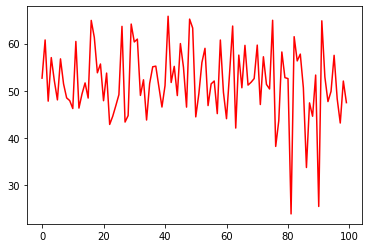

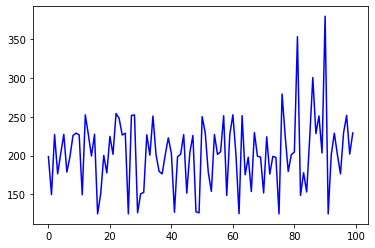

In [11]:
plt.plot(actor_loss,label="actor",color="red")
plt.show()
plt.plot(critic_loss,label="critic",color="blue")


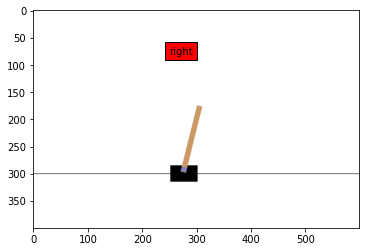

score:  30


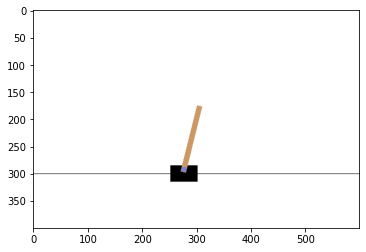

In [29]:
state = env.reset()
done = False
display_img = plt.imshow(env.render("rgb_array"))
i = 0
while not done:
  state = torch.tensor(state,dtype=torch.float,device="cuda")
  act = actor.get_action(torch.tensor(state,dtype=torch.float,device="cuda"))
  state, reward, done, _ = env.step(act)
  if act == 0:
    action_text = "left"
    bbox_color = "green"
  else:
    action_text = "right"
    bbox_color = "red"

  plot_action_text = plt.text(250,80,action_text,bbox=dict(facecolor=bbox_color))
 
  display_img.set_data(env.render("rgb_array"))
  clear_output(wait=True)
  display.display(plt.gcf())
  i += 1
  plot_action_text.remove()

print("score: ",i)